In [1]:
import os
import pathlib
from datetime import datetime
import librosa
import librosa.display as ld
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Audio
from tqdm import tqdm
import tensorflow as tf
print(f'[INFO] tensorflow: {tf.__version__}')
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import (Activation, Conv1D, Dense, Dropout, Flatten, MaxPooling1D)
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns

[INFO] tensorflow: 2.15.0


In [2]:
modalitys = [] # Modalidade (01 = Av completo, 02 = apenas video, 03 = apenas audio)
voc_channels = [] # Canal vocal (01 = fala, 02 = música)
emotions = [] # Emoção (01 = neutro, 02 = calma, 03 = feliz, 04 = triste, 05 = zangado, 06 = com medo, 07 = nojo, 08 = surpreso)
intensitys = [] #Intensidade emocional (01 = normal, 02 = forte)
phrases = [] # Frase (01 = "Crianças conversam perto da porta", 02 = "Cachorros estão sentados na porta")
actors = []# Ator (01 a 24. Os atores com números ímpares são homens, os atores com números pares são mulheres)

full_path = []


def create_dataset(dataset):
  for root, dirs, files in tqdm(os.walk(dataset)):
    for file in files:
      try:
        modal = int(file[1:2])
        vchan = int(file[4:5])
        label = int(file[7:8])
        ints = int(file[10:11])
        phr = int(file[13:14])
        act = int(file[19:20])

        modalitys.append(modal)
        voc_channels.append(vchan)
        emotions.append(label)
        intensitys.append(ints)
        phrases.append(phr)
        actors.append(act)

        full_path.append((root, file))


      except ValueError:
        continue


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
create_dataset('/content/drive/MyDrive/colab/passo1')

25it [00:06,  3.73it/s]


In [4]:
create_dataset('/content/drive/MyDrive/colab/passo2')

0it [00:00, ?it/s]


In [14]:
emotion_list = ['neutra', 'calma', 'feliz', 'triste', 'nervosa', 'medo', 'nojo', 'surpreso']
emotion_dict = {em[0] + 1:em[1] for em in enumerate(emotion_list)}
emotion_dict

{1: 'neutra',
 2: 'calma',
 3: 'feliz',
 4: 'triste',
 5: 'nervosa',
 6: 'medo',
 7: 'nojo',
 8: 'surpreso'}

In [15]:
df = pd.DataFrame([emotions, voc_channels, modalitys, intensitys, actors, phrases, full_path]).T

In [16]:
df.columns = ['emotion', 'voc_channel', 'modality', 'intensity', 'actors', 'phrase', 'path']
df

,emotion,voc_channel,modality,intensity,actors,phrase,path
0,1,1,3,1,1,1,"(/content/drive/MyDrive/colab/passo1/Actor_01,..."
1,2,1,3,1,1,1,"(/content/drive/MyDrive/colab/passo1/Actor_01,..."
2,1,1,3,1,1,2,"(/content/drive/MyDrive/colab/passo1/Actor_01,..."
3,1,1,3,1,1,1,"(/content/drive/MyDrive/colab/passo1/Actor_01,..."
4,2,1,3,1,1,2,"(/content/drive/MyDrive/colab/passo1/Actor_01,..."
...,...,...,...,...,...,...,...
1435,8,1,3,1,4,1,"(/content/drive/MyDrive/colab/passo1/Actor_24,..."
1436,8,1,3,1,4,2,"(/content/drive/MyDrive/colab/passo1/Actor_24,..."
1437,7,1,3,1,4,2,"(/content/drive/MyDrive/colab/passo1/Actor_24,..."
1438,8,1,3,2,4,2,"(/content/drive/MyDrive/colab/passo1/Actor_24,..."


In [17]:
df['emotion'] = df['emotion'].map(emotion_dict)
df['voc_channel'] = df['voc_channel'].map({1: 'fala', 2: 'musica'})
df['modality'] = df['modality'].map({1: 'Av completo', 2: 'apenas video', 3: 'apenas audio'})
df['intensity'] = df['intensity'].map({1: 'normal', 2: 'forte'})
df['actors'] = df['actors'].apply({lambda x: 'feminino' if x % 2 == 0 else 'masculino'})
df['phrase'] = df['phrase'].map({1: 'Kids are talking by the door', 2: 'Dogs are sitting by the door'})
df['path'] = df['path'].apply(lambda x: x[0] + '/' + x[1])
df

,emotion,voc_channel,modality,intensity,actors,phrase,path
0,neutra,fala,apenas audio,normal,masculino,Kids are talking by the door,/content/drive/MyDrive/colab/passo1/Actor_01/0...
1,calma,fala,apenas audio,normal,masculino,Kids are talking by the door,/content/drive/MyDrive/colab/passo1/Actor_01/0...
2,neutra,fala,apenas audio,normal,masculino,Dogs are sitting by the door,/content/drive/MyDrive/colab/passo1/Actor_01/0...
3,neutra,fala,apenas audio,normal,masculino,Kids are talking by the door,/content/drive/MyDrive/colab/passo1/Actor_01/0...
4,calma,fala,apenas audio,normal,masculino,Dogs are sitting by the door,/content/drive/MyDrive/colab/passo1/Actor_01/0...
...,...,...,...,...,...,...,...
1435,surpreso,fala,apenas audio,normal,feminino,Kids are talking by the door,/content/drive/MyDrive/colab/passo1/Actor_24/0...
1436,surpreso,fala,apenas audio,normal,feminino,Dogs are sitting by the door,/content/drive/MyDrive/colab/passo1/Actor_24/0...
1437,nojo,fala,apenas audio,normal,feminino,Dogs are sitting by the door,/content/drive/MyDrive/colab/passo1/Actor_24/0...
1438,surpreso,fala,apenas audio,forte,feminino,Dogs are sitting by the door,/content/drive/MyDrive/colab/passo1/Actor_24/0...


WaveForms



Canais:  (168168,)
Número total de amostras:  168168
Arquivo:  /content/drive/MyDrive/colab/passo1/Actor_24/03-01-02-01-01-02-24.wav
Taxa de amostragem:  48000
Duração:  3.5035


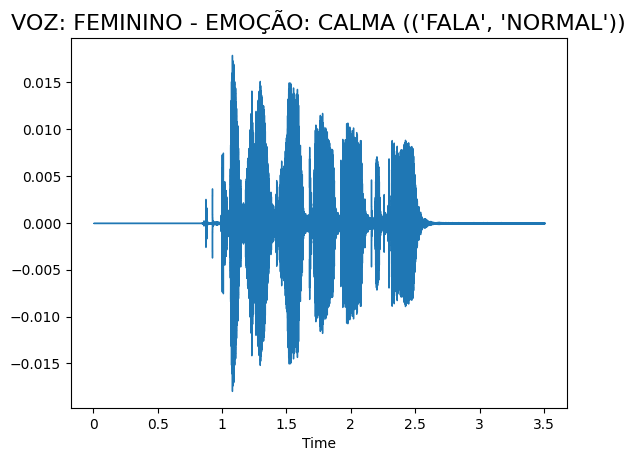

In [18]:
n_files = df.shape[0]
rnd = np.random.randint(0, n_files)

fname = df.path[rnd]
data, sample_rate = librosa.load(fname, sr = None)

print('Canais: ', data.shape)
print('Número total de amostras: ', data.shape[0])
print('Arquivo: ', fname)
print('Taxa de amostragem: ', sample_rate)
print('Duração: ', len(data) / sample_rate)



info = df.iloc[rnd].values
title_txt = f'voz: {info[4]} - emoção: {info[0]} ({info[1], info[3]})'
plt.title(title_txt.upper(), size=16)
ld.waveshow(data, sr = sample_rate)
Audio(data = data, rate = sample_rate)

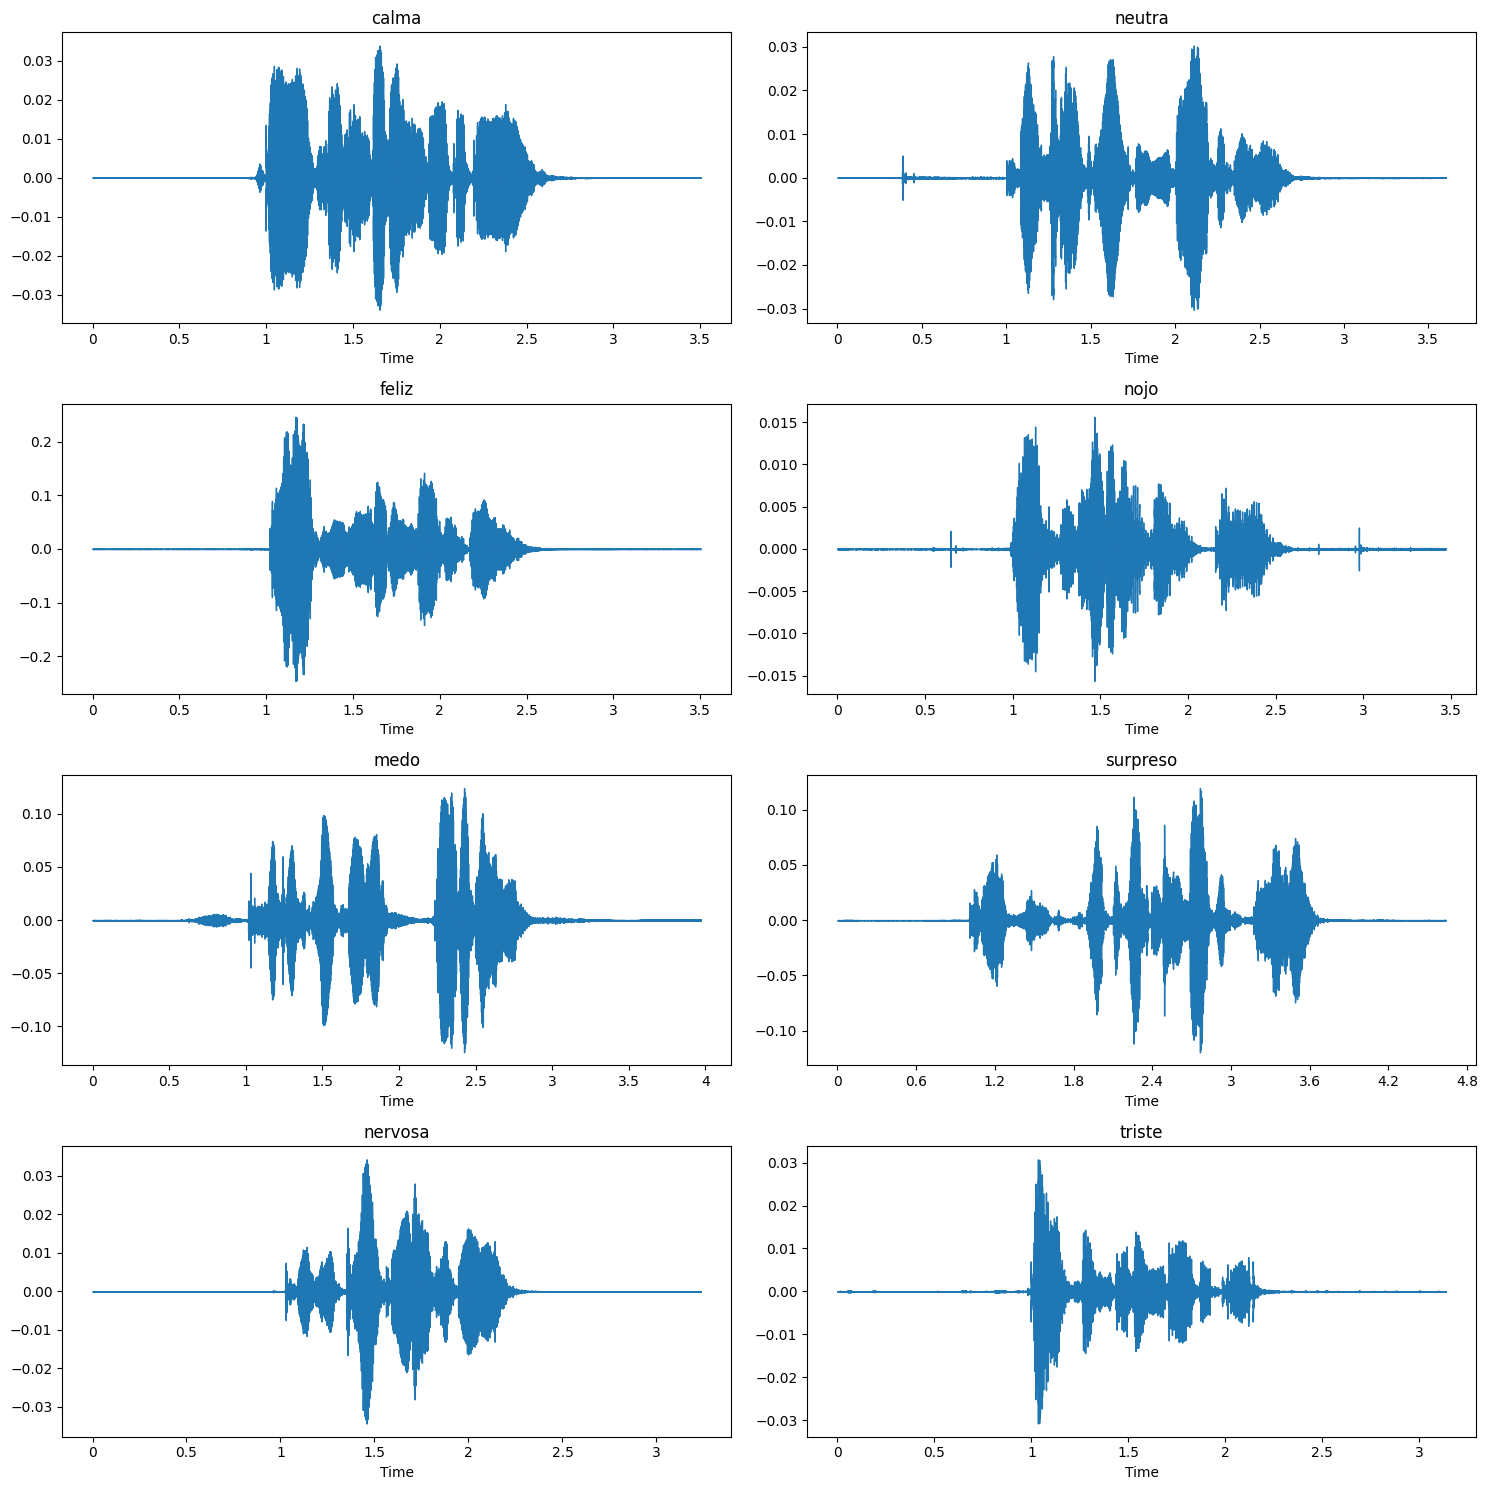

In [19]:
random_samples = df.groupby('emotion').sample(1)
audio_samples, labels = random_samples['path'].tolist(), random_samples['emotion'].tolist()

rows = 4
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
index = 0

for col in range(cols):
  for row in range(rows):
    data, sample_rate = librosa.load(audio_samples[index], sr = None)
    ld.waveshow(data, sr = sample_rate, ax = axs[row][col])
    axs[row][col].set_title('{}'.format(labels[index]))
    index += 1

fig.tight_layout()

Espectogramas de STFT

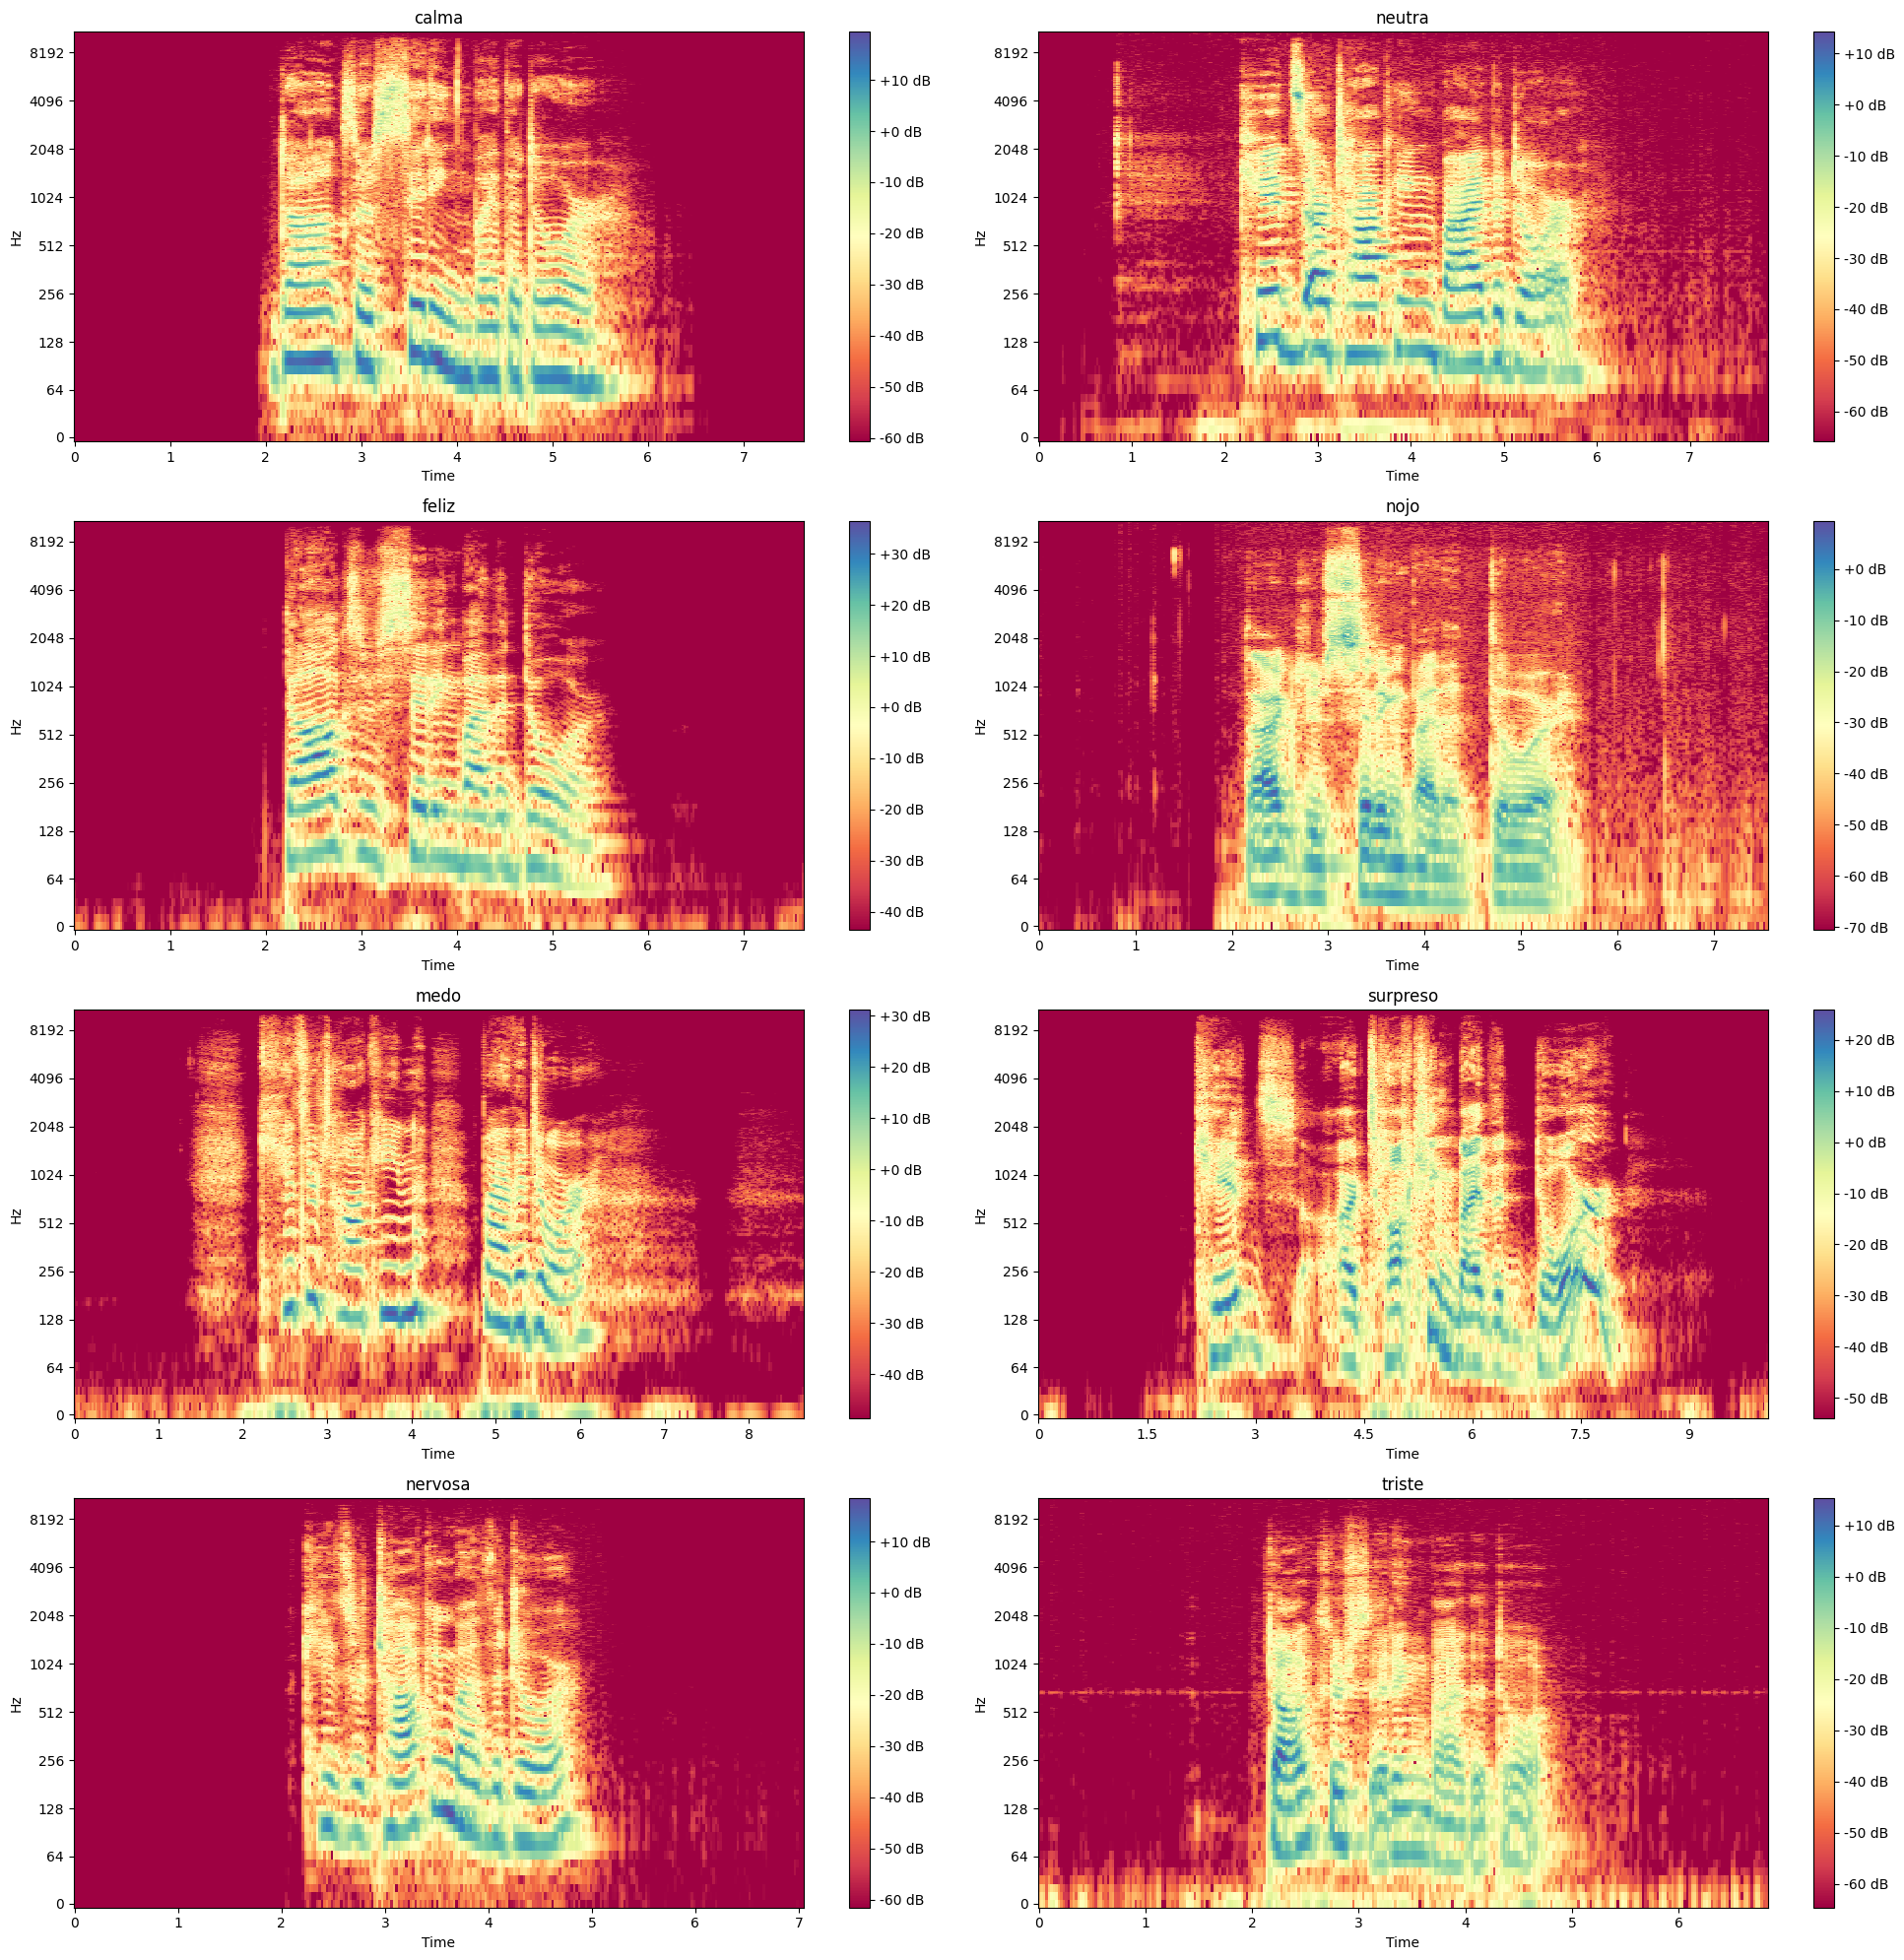

In [20]:
fig, axs = plt.subplots(rows, cols, figsize=(20,20))
index = 0
for col in range(cols):
  for row in range(rows):
    data, sample_rate = librosa.load(audio_samples[index], sr = None)
    stft = librosa.stft(y = data)
    stft_db = librosa.amplitude_to_db(np.abs(stft))
    img = librosa.display.specshow(stft_db, x_axis="time", y_axis='log', ax = axs[row][col], cmap = 'Spectral')
    axs[row][col].set_title('{}'.format(labels[index]))
    fig.colorbar(img, ax = axs[row][col], format='%+2.f dB')
    index += 1

fig.tight_layout()

Espectrogramas de MFCCs

In [ ]:
fig, axs = plt.subplots(rows, cols, figsize=(20,20))
index = 0
for col in range(cols):
  for row in range(rows):
    data, sample_rate = librosa.load(audio_samples[index], sr = None)
    mfccs = librosa.feature.mfcc(y = data, sr = sample_rate, n_mfcc = 40)
    mfccs_db = librosa.amplitude_to_db(np.abs(mfccs))
    img = librosa.display.specshow(mfccs_db, x_axis = "time", y_axis='log', ax = axs[row][col], cmap = 'Spectral')
    axs[row][col].set_title('{}'.format(labels[index]))
    fig.colorbar(img, ax = axs[row][col], format='%+2.f dB')
    index += 1

fig.tight_layout()

Pré - processamento
Extraindo recursos / características MFCC's

In [ ]:
def features_extractor(file_name):
  data, sample_rate = librosa.load(file_name, sr = None, res_type = 'kaiser_fast')
  mfccs_features = librosa.feature.mfcc(y = data, sr = sample_rate, n_mfcc = 40)
  mfccs_scaled_features = np.mean(mfccs_features.T, axis = 0)
  return mfccs_scaled_features

extractd_features = []
for path in tqdm(df.path.values):
  data = features_extractor(path)
  extractd_features.append([data])

100%|██████████| 4320/4320 [02:25<00:00, 29.71it/s]


Convertendo os recursos extraídos

In [ ]:
extracted_features_df =  pd.DataFrame(extractd_features, columns = ['feature'])
extracted_features_df

,feature
0,"[-536.6904, 43.285828, -9.279314, 9.257221, -1..."
1,"[-522.467, 43.700798, -14.606612, 12.619474, -..."
2,"[-534.35126, 53.048775, -19.99443, -2.8204713,..."
3,"[-543.7976, 52.419262, -20.447172, 5.142262, -..."
4,"[-698.7616, 43.0703, -5.4789057, 7.9784985, -7..."
...,...
4315,"[-695.99194, 73.905, -10.055801, 7.9084697, -6..."
4316,"[-718.60034, 60.42959, -7.504327, 8.469443, 0...."
4317,"[-698.5949, 80.241234, -13.513393, 3.7782693, ..."
4318,"[-680.5748, 71.79892, -4.8794627, 10.461559, -..."


In [ ]:
from pandas.core.common import random_state
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(df.emotion.tolist())
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

X_train.shape
X_test.shape
Y_train.shape
Y_test.shape


(864, 8)

In [ ]:
model = Sequential()
model.add(Conv1D(64, kernel_size=(5), activation='relu', input_shape=(X_train.shape[1], 1)))

model.add(Conv1D(128, kernel_size=(5), activation='relu', padding = 'same'))
model.add(MaxPooling1D(pool_size=(5)))

model.add(Conv1D(256, kernel_size=(5), activation = 'relu', padding='same'))
model.add(MaxPooling1D(pool_size=(5)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(8))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 36, 64)            384       
                                                                 
 conv1d_7 (Conv1D)           (None, 36, 128)           41088     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 7, 128)            0         
 g1D)                                                            
                                                                 
 conv1d_8 (Conv1D)           (None, 7, 256)            164096    
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 1, 256)            0         
 g1D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 1, 256)           

In [ ]:
num_epochs = 50
num_batch_size = 64

checkpointer = ModelCheckpoint(filepath='/content/saved_models/speech_emotion_recognition.h5', verbose=1, save_best_only = True)
start = datetime.now()
model_history = model.fit(X_train, Y_train, batch_size= num_batch_size, epochs= num_epochs, validation_data=(X_test, Y_test), callbacks=[checkpointer], verbose =1)
duration = datetime.now() - start

print('[INFO] treinamento concluído em: ', duration)




Epoch 1/50
45/54 [========================>.....] - ETA: 0s - loss: 2.8788 - accuracy: 0.1670
Epoch 1: val_loss improved from inf to 1.95624, saving model to /content/saved_models/speech_emotion_recognition.h5
54/54 [==============================] - 2s 10ms/step - loss: 2.7300 - accuracy: 0.1814 - val_loss: 1.9562 - val_accuracy: 0.2488
Epoch 2/50
38/54 [====================>.........] - ETA: 0s - loss: 1.8875 - accuracy: 0.2903

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/54 [==========================>...] - ETA: 0s - loss: 1.8664 - accuracy: 0.2959
Epoch 2: val_loss improved from 1.95624 to 1.72856, saving model to /content/saved_models/speech_emotion_recognition.h5
54/54 [==============================] - 0s 6ms/step - loss: 1.8591 - accuracy: 0.2989 - val_loss: 1.7286 - val_accuracy: 0.3102
Epoch 3/50
51/54 [===========================>..] - ETA: 0s - loss: 1.6786 - accuracy: 0.3716
Epoch 3: val_loss improved from 1.72856 to 1.59205, saving model to /content/saved_models/speech_emotion_recognition.h5
54/54 [==============================] - 0s 6ms/step - loss: 1.6765 - accuracy: 0.3724 - val_loss: 1.5921 - val_accuracy: 0.4178
Epoch 4/50
50/54 [==========================>...] - ETA: 0s - loss: 1.5330 - accuracy: 0.4422
Epoch 4: val_loss improved from 1.59205 to 1.35435, saving model to /content/saved_models/speech_emotion_recognition.h5
54/54 [==============================] - 0s 6ms/step - loss: 1.5234 - accuracy: 0.4453 - val_loss: 1.3544 - val

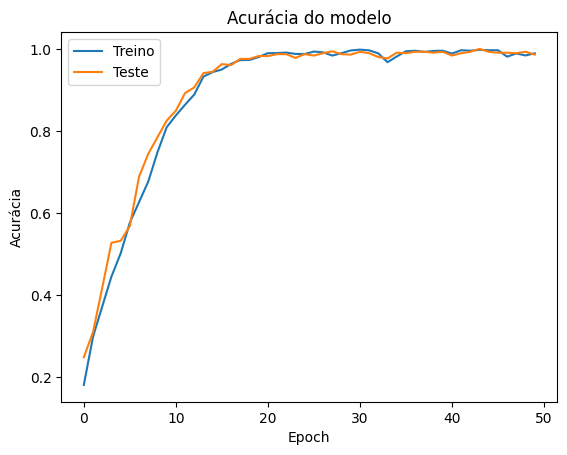

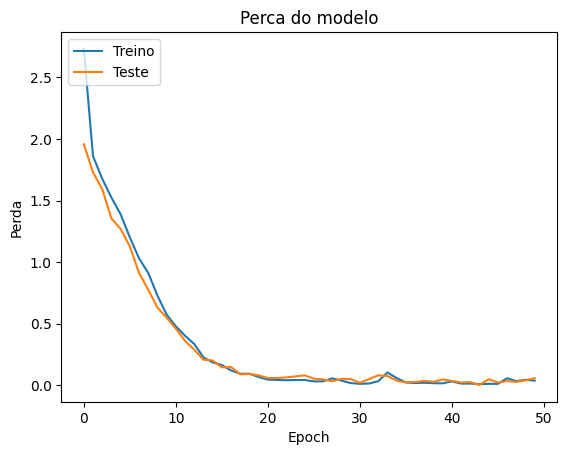

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Acurácia do modelo')
plt.ylabel('Acurácia')
plt.xlabel('Epoch')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Perca do modelo')
plt.ylabel('Perda')
plt.xlabel('Epoch')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()

Testando o modelo em arquivos de áudio

In [ ]:
def getInfo(data, sample_rate):
  print('Canais: ', data.shape[0])
  print('Número total de amostras: ', data.shape[0])
  print('Taxa de amostragem: ', sample_rate)
  print('Duração: ', len(data) / sample_rate)


def predictSound(AUDIO, info = False, plot_waveform = False, plot_spectrogram = False):
  audio, sample_rate = librosa.load(AUDIO, sr = None, res_type='kaiser_fast')
  mfccs_features = librosa.feature.mfcc(y = audio, sr = sample_rate, n_mfcc=40)
  mfccs_scaled_features = np.mean(mfccs_features.T, axis = 0)
  mfccs_scaled_features = mfccs_scaled_features.reshape(1, -1)
  mfccs_scaled_features = mfccs_scaled_features[:, :, np.newaxis]
  predictions = model.predict(mfccs_scaled_features, batch_size= 32)
  plt.barh(labelencoder.classes_, predictions[0], color = list('rgbkymc'))
  predictions = predictions.argmax(axis = 1)
  predictions = np.array(predictions)
  predictions = predictions.flatten()
  predictions = (labelencoder.inverse_transform((predictions)))
  print('Resultado:', predictions)

  if info:
    getInfo(audio, sample_rate)

  if plot_waveform:
    plt.figure(figsize=(14, 5))
    plt.title('Emoção: ' + str(predictions[0]).upper(), size = 16)
    plt.xlabel('Tempo (segundos) ==>')
    plt.ylabel('Amplitude')
    ld.waveshow(audio, sr = sample_rate)

  if plot_spectrogram:
    plt.figure(figsize = (14, 5))
    mfccs_db = librosa.amplitude_to_db(np.abs(mfccs))
    plt.title('Emoção: ' + str(predictions[0]).upper(), size = 16)
    ld.specshow(mfccs_db, x_axis='time', y_axis='log', cmap = 'Spectral')
    plt.colorbar(format = '%2.f fb')

In [ ]:
AUDIO = "/content/drive/MyDrive/colab/controle1.wav"
audio, sample_rate = librosa.load(AUDIO, sr = None, res_type= 'kaiser_fast')
Audio(data = audio, rate = sample_rate)

1/1 [==============================] - 0s 104ms/step
Resultado: ['feliz']
Canais:  385739
Número total de amostras:  385739
Taxa de amostragem:  48000
Duração:  8.036229166666667


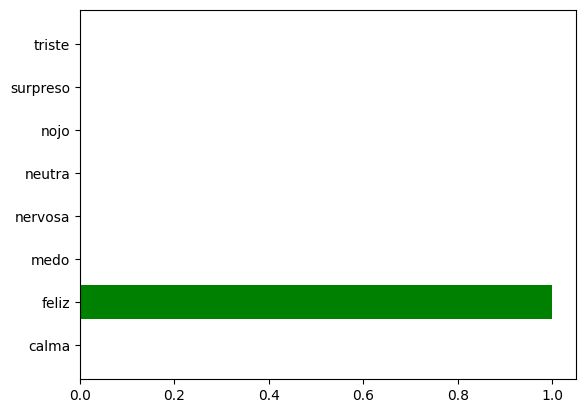

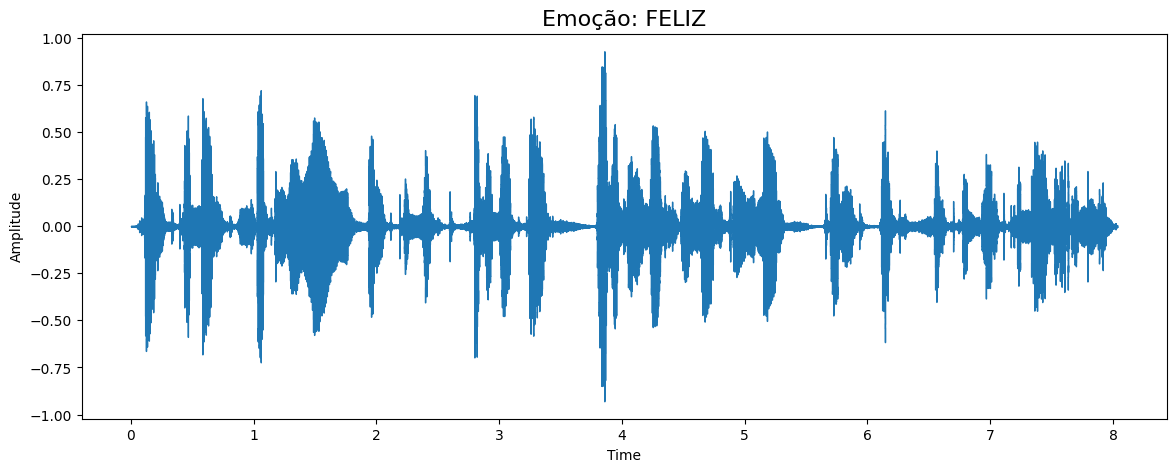

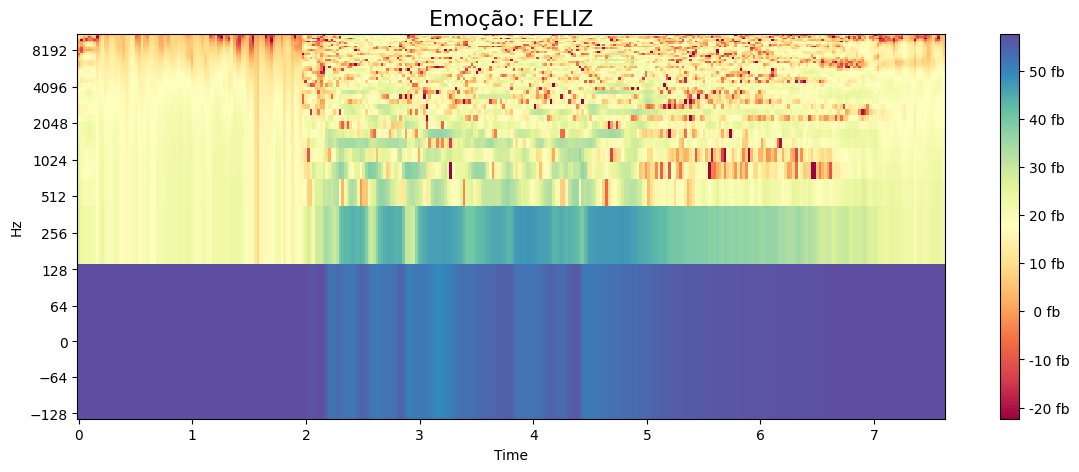

In [ ]:
predictSound(AUDIO, info = True, plot_waveform= True, plot_spectrogram = True)